# Housing Prices Regression

In this project we will try to predict housing prices in California using Machine Learning.

## Housing Prices Regression – EDA

Exploring the California Housing dataset and performing initial data analysis.  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing

# Visualization settings
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

## Load the dataset
Load the California Housing dataset from sklearn into a Pandas DataFrame.
italicized text

In [ ]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## First look at the data
Check the data types and basic statistics.


In [ ]:
print("\nGeneral info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe().T)


General info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Basic statistics:
               count         mean          std         min         25%  \
MedInc       20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge     20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms     20640.0     5.429000     2.474173    0.846154    4.440716   
AveBedrms    20640.0     1.096675     0.473911    0.333

## Missing values
Check for missing values in each column.


In [ ]:
df.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


## Target and features distribution
We will examine how the target variable (Median House Value) and the features  ate distributed.


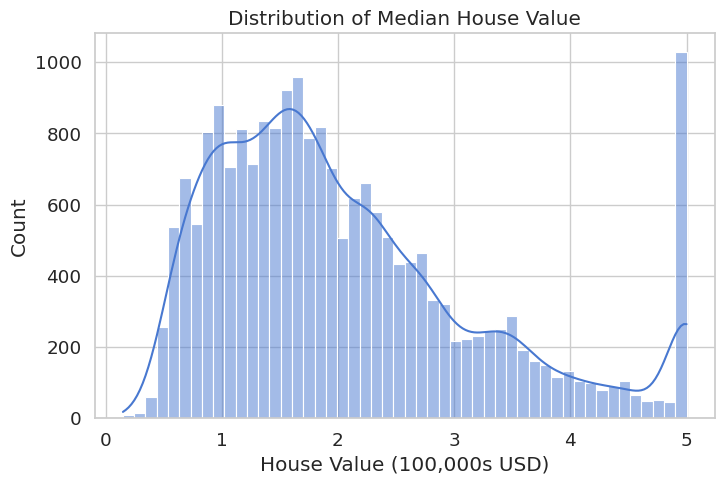

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df["MedHouseVal"], bins=50, kde=True)
plt.title("Distribution of Median House Value")
plt.xlabel("House Value (100,000s USD)")
plt.ylabel("Count")
plt.show()

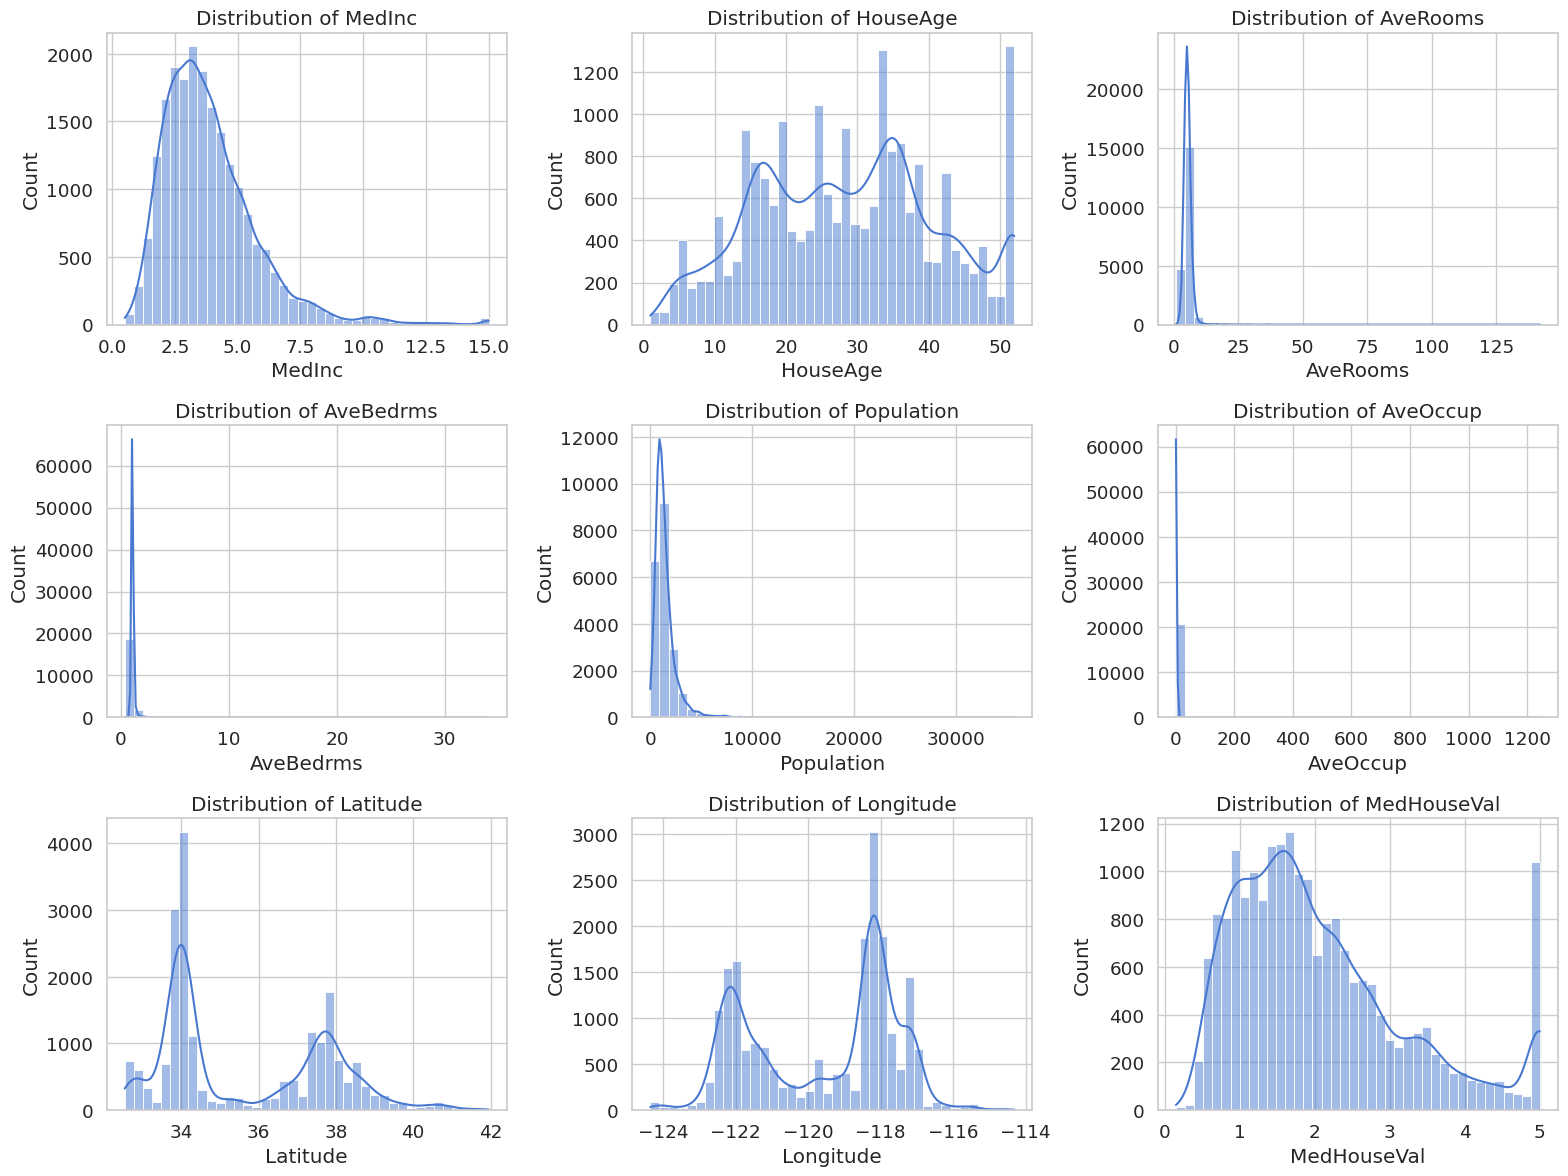

In [ ]:
num_cols = df.columns

plt.figure(figsize=(16,12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=40)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

## Outliers Detection  
Boxplots are used to identify extreme values in the dataset.  
Points outside the whiskers may indicate potential outliers that could affect model performance.  


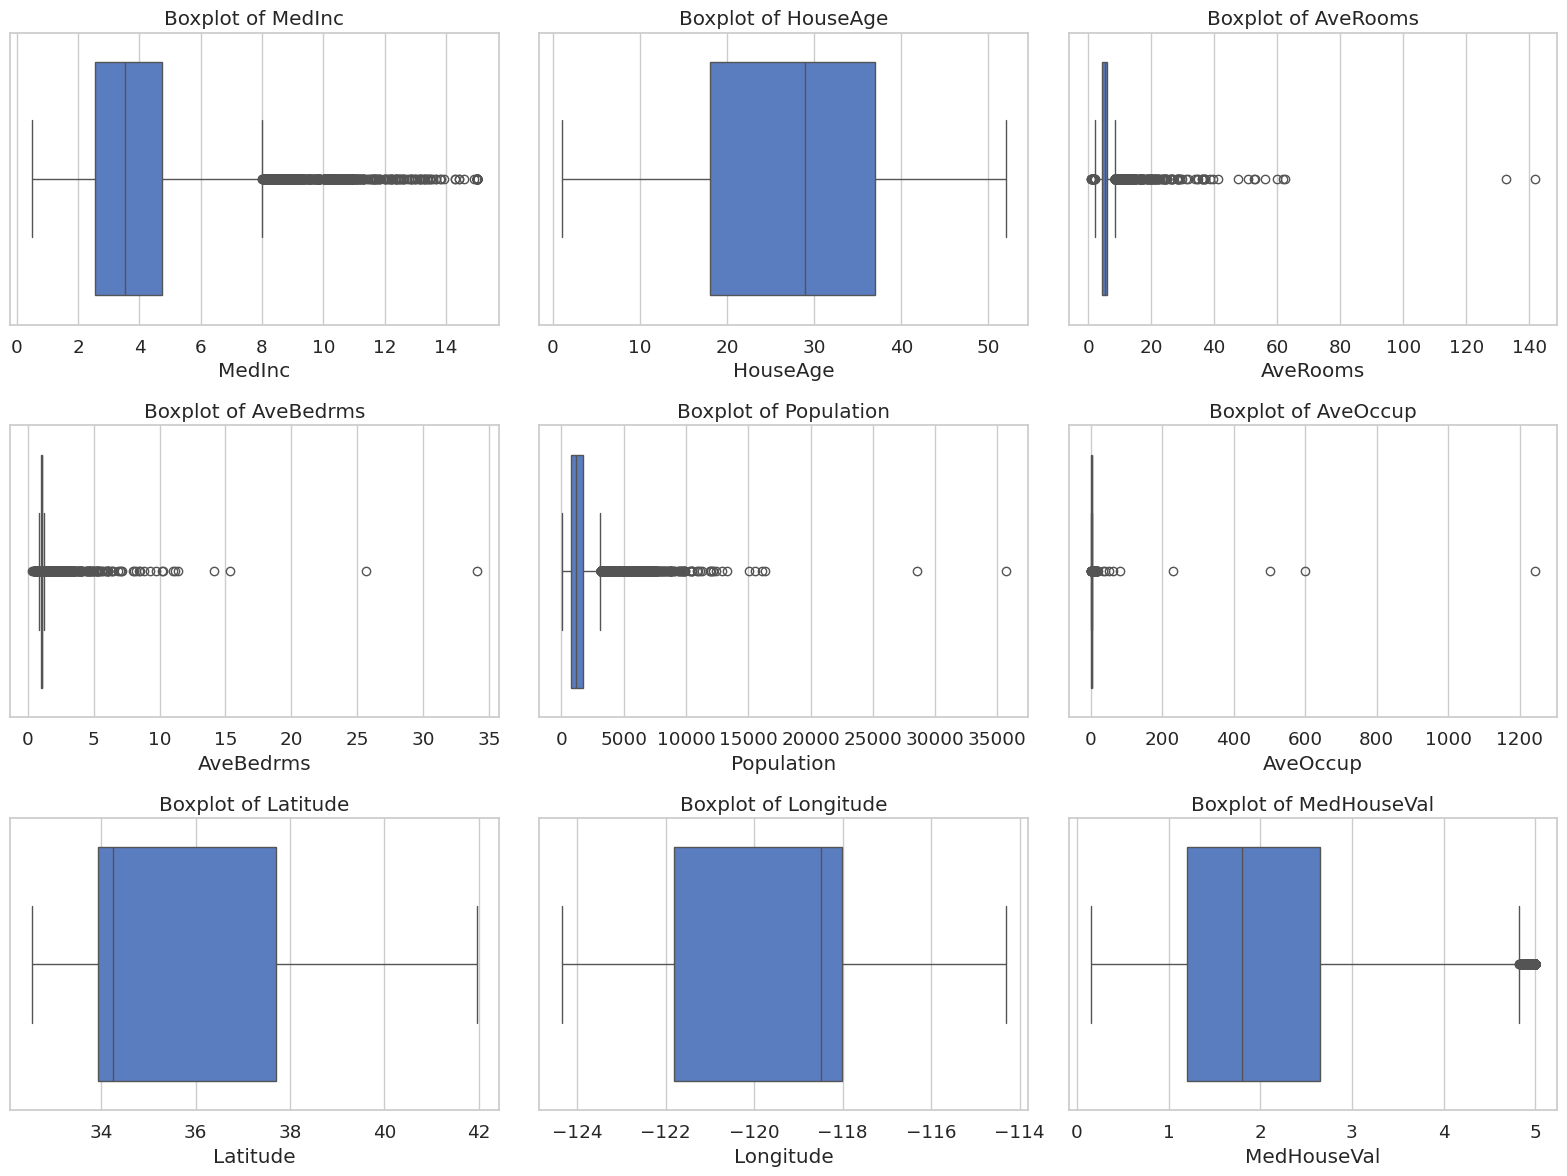

In [ ]:
plt.figure(figsize=(16,12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


## Feature–Target Relationships  
Scatterplots are used to visualize the relationship between each feature and the target variable.  
They help identify linear or non-linear patterns, as well as noisy or weak correlations.

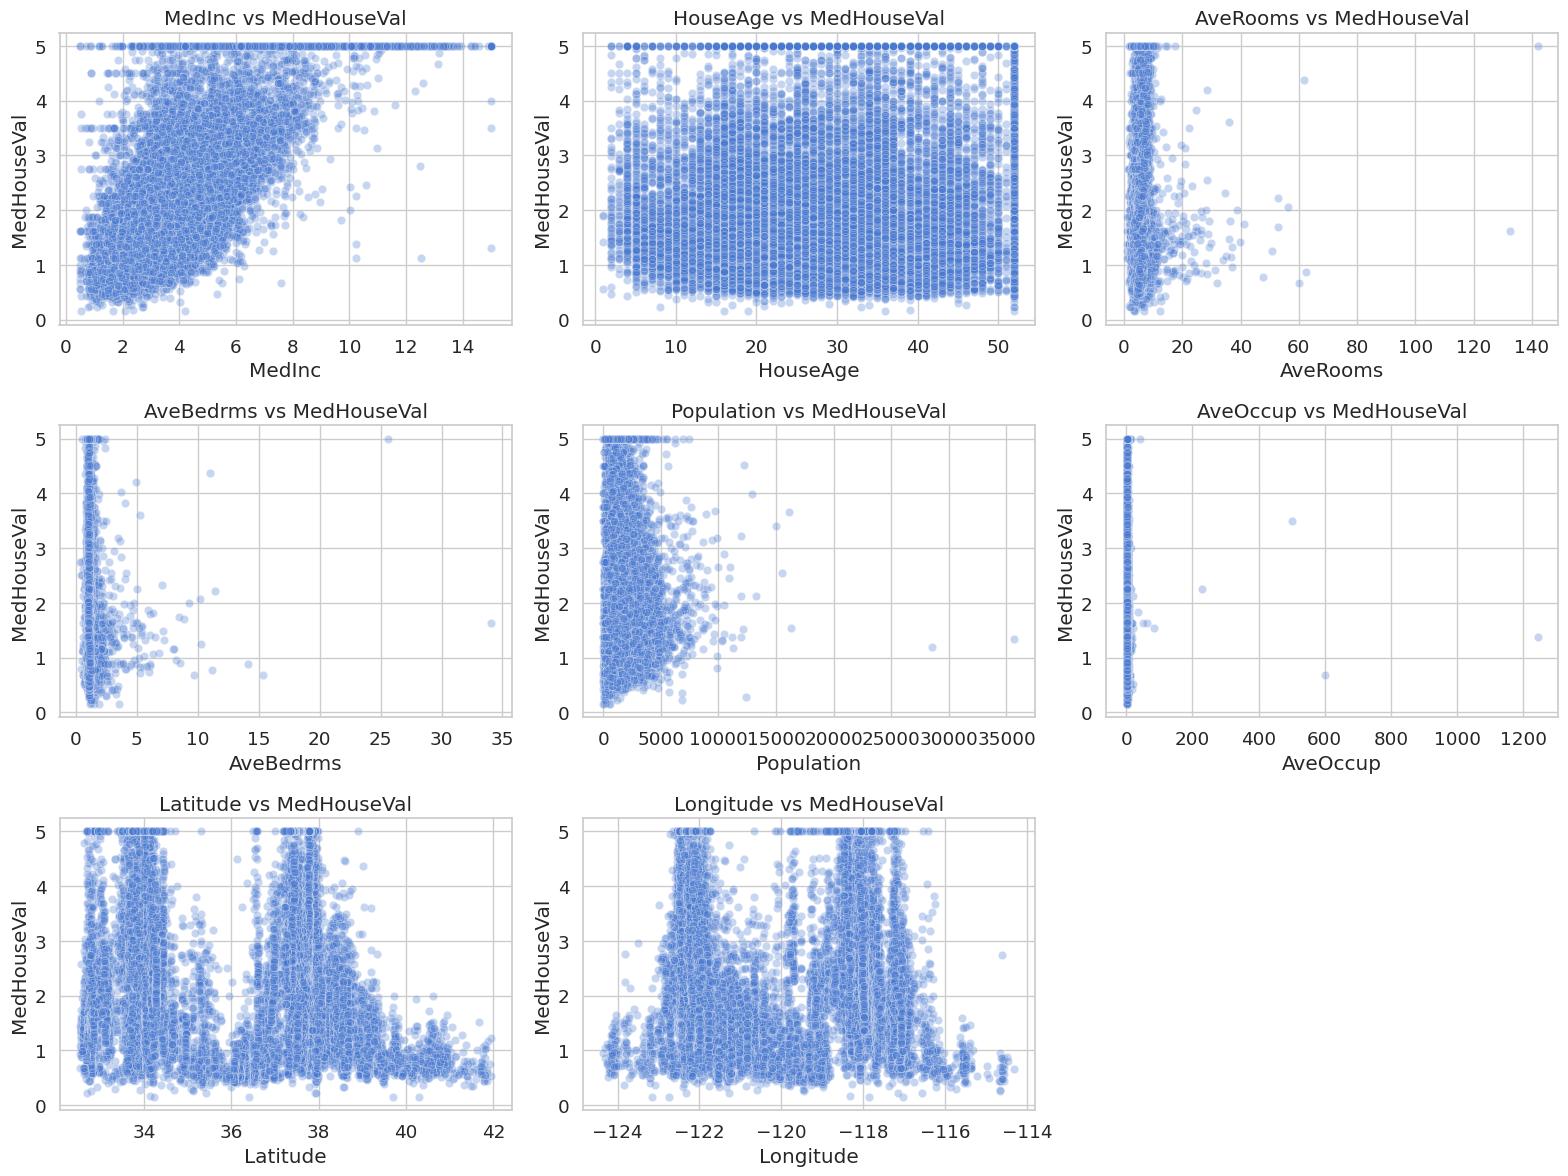

In [ ]:
target = "MedHouseVal"
features = [col for col in df.columns if col != target]

plt.figure(figsize=(16,12))
for i, col in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(x=df[col], y=df[target], alpha=0.3)
    plt.title(f"{col} vs {target}")
plt.tight_layout()
plt.show()


## Correlation heatmap
Check which features are strongly correlated with the target (house value).


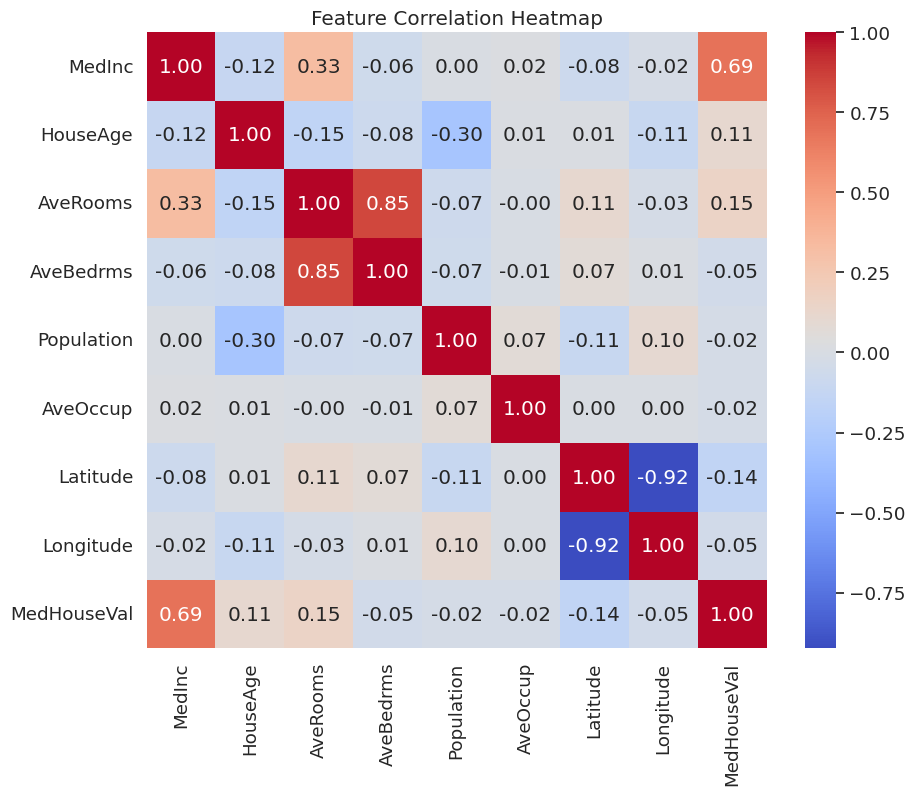

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# EDA Summary
- No missing values in the dataset.

- Target (MedHouseVal): most house values are concentrated below 3 ($300,000).

- Correlation: MedInc (Median Income) shows the strongest positive correlation with housing prices. Other features show weaker or noisy relationships.

- Geographic features (Latitude, Longitude): not informative on their own, but may be useful when combined (location effects).

- Outliers detected in MedInc, AveRooms, AveBedrms, Population, and AveOccup.

- Feature distributions: several features are skewed, suggesting possible transformations (e.g., log-scaling).

- Scatterplots reveal that most features have no clear linear relationship with housing prices, except for MedInc.

# Preprocessing & Baseline Model

In this section, we prepare the California Housing dataset for machine learning.  
We will handle skewed features, split the data into train/test sets, standardize features, and run a baseline Linear Regression model.


## Load Dataset

We load the California Housing dataset and separate features and target variable.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
housing = fetch_california_housing(as_frame=True)
df = housing.frame

target = "MedHouseVal"
features = [col for col in df.columns if col != target]

X = df[features].copy()
y = df[target].copy()

print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (20640, 8)
Target shape: (20640,)


## Log-transform Skewed Features

Based on EDA, some features have skewed distributions.  
We apply log-transform (log1p) to reduce skewness and mitigate extreme values.

Skewed features: `Population`, `AveOccup`, `AveRooms`, `AveBedrms`.


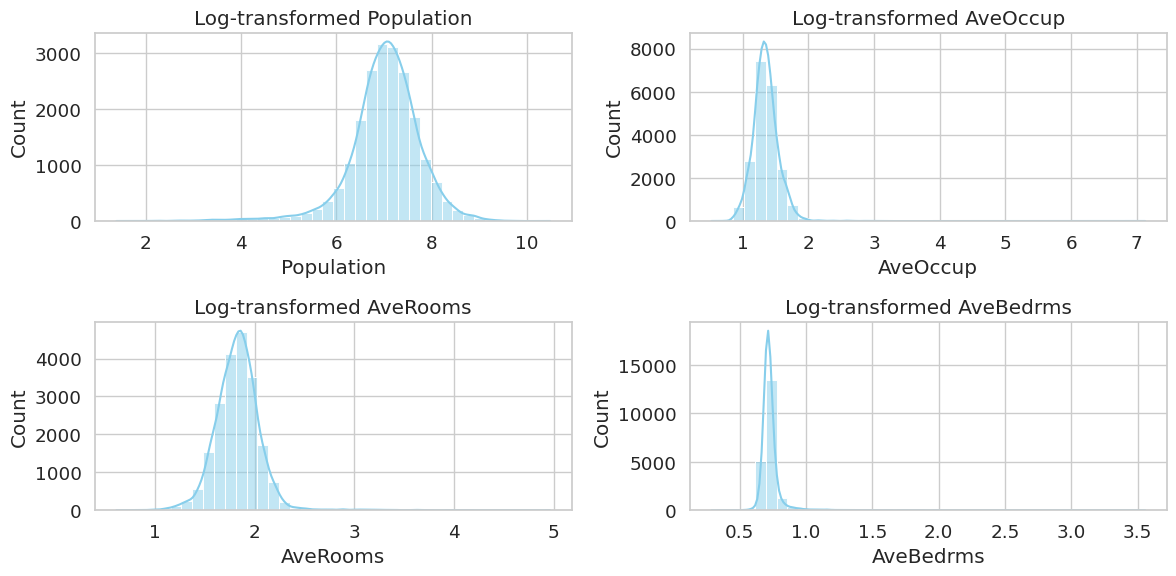

In [ ]:
skewed_features = ['Population', 'AveOccup', 'AveRooms', 'AveBedrms']
X[skewed_features] = X[skewed_features].apply(lambda x: np.log1p(x))

# visualize transformed features
plt.figure(figsize=(12,6))
for i, col in enumerate(skewed_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(X[col], kde=True, bins=40, color='skyblue')
    plt.title(f"Log-transformed {col}")
plt.tight_layout()
plt.show()


## Train/Test Split

Split the dataset into training and test sets (80/20 split).  
Random state is fixed for reproducibility.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Standardization

StandardScaler is applied to normalize features (mean=0, std=1).  
Important for models sensitive to feature scale (Linear Regression, Neural Networks).


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Baseline Model – Linear Regression

Linear Regression provides a simple benchmark to evaluate feature usefulness and overall performance.


In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.3f}")
print(f"Linear Regression R^2: {r2:.3f}")



Linear Regression RMSE: 0.683
Linear Regression R^2: 0.644


## Linear Models

In this section, we apply polynomial regression with Ridge regularization using a pipeline.  
We use GridSearchCV to tune two hyperparameters: the polynomial degree and the Ridge regularization strength (alpha).  
The goal is to find the best trade-off between model complexity and generalization performance.





In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'poly__degree': [1,2,3,4,5],
    'ridge__alpha': [0.01, 0.1, 1, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print("Best params:", grid.best_params_)
print("Train R²:", grid.best_score_)
print("Test R²:", grid.score(X_test, y_test))
print(f"RMSE: {rmse:.3f}")


Best params: {'poly__degree': 3, 'ridge__alpha': 1}
Train R²: 0.7323719760785663
Test R²: 0.7319972578952433
RMSE: 0.593


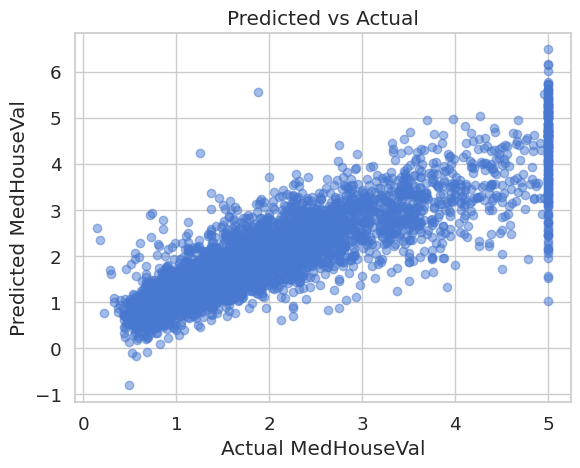

In [ ]:
import matplotlib.pyplot as plt

y_pred = grid.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual MedHouseVal")
plt.ylabel("Predicted MedHouseVal")
plt.title("Predicted vs Actual")
plt.show()


### Model Evaluation (Polynomial Ridge Regression)

Using GridSearchCV, the best model was found with degree=3 and alpha=1.  
The model achieves consistent performance on both training and test sets (Train R² ≈ 0.73, Test R² ≈ 0.73), indicating good generalization.  

The scatter plot of predicted vs. actual values shows a clear positive trend, although with some variance and underestimation at higher house values. This suggests the model captures the general relationship but struggles with extreme cases.


# Non-linear Models - Random Forest & XGBoost
In this section, we apply non-linear models to the California Housing dataset.  
We will use Random Forest and Gradient Boosting, evaluate their performance, and visualize feature importance.


## Random Forest Regressor

### Random Forest Baseline

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf =  RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Training R²:", rf.score(X_train, y_train))
print("Test R²:", rf.score(X_test, y_test))
print(f"RMSE: {rmse:.3f}")

Training R²: 0.9735762017311032
Test R²: 0.8052922010092667
RMSE: 0.505


### RandomizedSearchCV for Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best RF params:", random_search.best_params_)
print("Best RF CV R²:", random_search.best_score_)


best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Test R²:", best_rf.score(X_test, y_test))
print("Training R²:", best_rf.score(X_train, y_train))
print(f"RMSE: {rmse:.3f}")


Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best RF CV R²: 0.8154605110974563
Test R²: 0.8137849027399173
Training R²: 0.9752239248358561
RMSE: 0.494


### Feature Importance - Random Forest

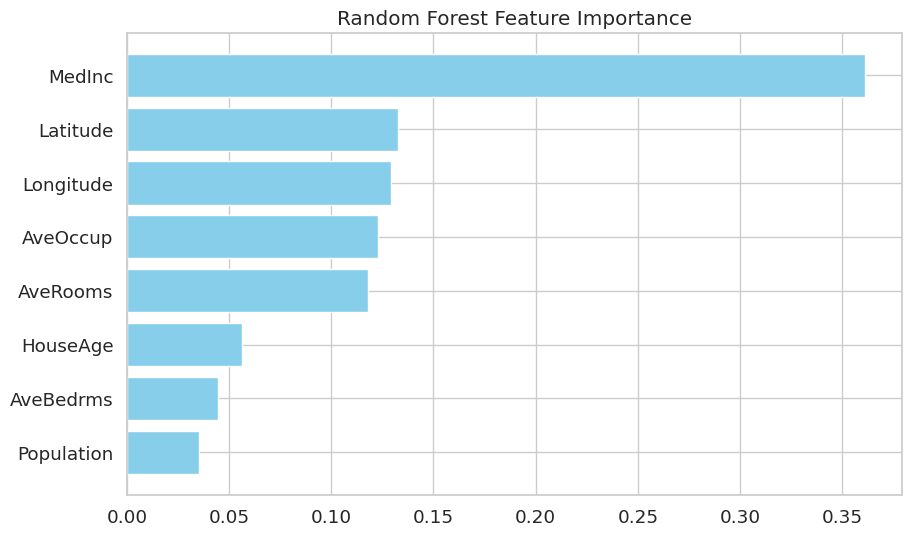

In [ ]:
importances = best_rf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color='skyblue')
plt.title("Random Forest Feature Importance")
plt.show()


In [ ]:
filtered_features = ['MedInc', 'Latitude', 'Longitude', 'AveOccup','AveRooms','HouseAge', 'Population']
X_filtered_train = X_train[filtered_features]
X_filtered_test = X_test[filtered_features]

In [ ]:
best_rf.fit(X_filtered_train, y_train)
y_pred = best_rf.predict(X_filtered_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print("Training R²:", best_rf.score(X_filtered_train, y_train))
print("Test R²:", best_rf.score(X_filtered_test, y_test))
print(f"RMSE: {rmse:.3f}")

Training R²: 0.9758554127825341
Test R²: 0.8181505808241283
RMSE: 0.488


## XGBoost Regressor

### RandomizedSearchCV for XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

xgb = XGBRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': np.arange(100, 2000, 100),
    'max_depth': np.arange(3, 10, 1),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.5, 1, 2]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter= 40,
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV R²:", random_search.best_score_)

best_xgb = random_search.best_estimator_

y_pred =best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Test R²:", best_xgb.score(X_test, y_test))
print("Training R²:", best_xgb.score(X_train, y_train))
print(f"RMSE: {rmse:.3f}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': np.int64(1000), 'max_depth': np.int64(7), 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV R²: 0.847438077527341
Test R²: 0.8552252048068961
Training R²: 0.9874262684086823
RMSE: 0.436


### GridSearchCV for XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

xgb = XGBRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [1000],
    'max_depth': [6, 7],
    'learning_rate': [0.04, 0.05, 0.06],
    'subsample': [0.75, 0.8],
    'colsample_bytree': [0.8, 0.85],
    'gamma': [0],
    'reg_alpha': [0.05, 0.1],
    'reg_lambda': [1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring= 'r2',
    cv=3,
    verbose=2,
    n_jobs=-1
)


grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print("Best params:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)

best_xgb = grid_search.best_estimator_

y_pred =best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Test R²:", best_xgb.score(X_test, y_test))
print("Training R²:", best_xgb.score(X_train, y_train))
print(f"RMSE: {rmse:.3f}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.04, 'max_depth': 7, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best CV R²: 0.8493066066935216
Test R²: 0.8570604466117943
Training R²: 0.9817663947915211
RMSE: 0.433


Feature Importance - XGBoost

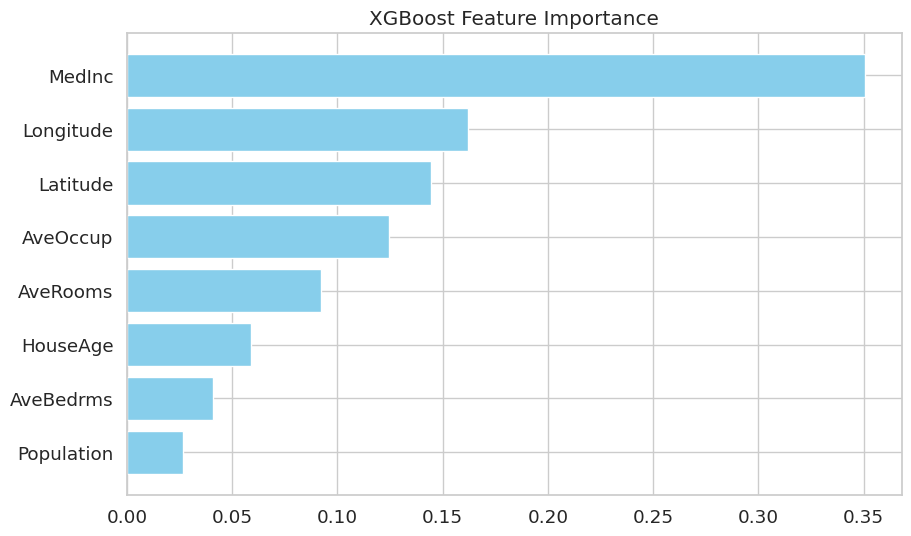

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


importances = best_xgb.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color='skyblue')
plt.title("XGBoost Feature Importance")
plt.show()


In [ ]:
filtered_features = ['MedInc','Longitude', 'Latitude', 'AveOccup','AveRooms','HouseAge']
X_filtered_train = X_train[filtered_features]
X_filtered_test = X_test[filtered_features]

In [ ]:
best_xgb.fit(X_filtered_train, y_train)
y_pred = best_xgb.predict(X_filtered_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


print("Training R²:", best_xgb.score(X_filtered_train, y_train))
print("Test R²:", best_xgb.score(X_filtered_test, y_test))
print(f"RMSE: {rmse:.3f}")

Training R²: 0.9741307703752464
Test R²: 0.8579616968982866
RMSE: 0.431


## Non-linear Models Summary:

Random Forest served as a baseline (Test R² ≈ 0.81, RMSE ≈ 0.49).
XGBoost achieved the best performance (Test R² ≈ 0.86, RMSE ≈ 0.43), confirming MedInc and location (Latitude, Longitude) as the most important predictors.

## Model Comparison Summary

In this project, we evaluated three types of models on the California Housing dataset:

1. **Linear Regression**  
   - Strengths: Simple, interpretable, and fast to train.  
   - Weaknesses: Limited in capturing non-linear relationships and interactions between features.  
   - Performance: Provided a baseline with modest predictive power. Useful as a reference point.

2. **Random Forest (RF)**  
   - Strengths: Handles non-linearities, robust to outliers, and less prone to overfitting compared to single decision trees.  
   - Weaknesses: Can be computationally expensive and harder to interpret than linear models.  
   - Performance: Achieved a clear improvement over Linear Regression by capturing complex feature interactions. Served as a strong baseline for non-linear models.

3. **XGBoost (XGB)**  
   - Strengths: Highly efficient gradient boosting framework, often achieving state-of-the-art results. Offers built-in regularization and handles feature importance well.  
   - Weaknesses: Requires careful hyperparameter tuning; can be sensitive to learning rate and depth.  
   - Performance: Outperformed both Linear Regression and Random Forest. Provided the best accuracy and generalization on this dataset.

---

### Final Notes
- **Linear Regression** → Best as a quick, interpretable baseline.  
- **Random Forest** → Solid non-linear baseline, improves significantly over linear models.  
- **XGBoost** → Best performing model, demonstrating the power of gradient boosting for structured tabular data.  

This progression illustrates the typical ML workflow:  
Start with a simple linear model → move to an ensemble baseline (RF) → apply a more advanced boosting method (XGB) for optimal performance.

## Model Comparison Table

| Model              | Strengths                                                                 | Weaknesses                                                       | Performance Summary |
|--------------------|---------------------------------------------------------------------------|------------------------------------------------------------------|---------------------|
| **Linear Regression** | - Simple & fast  <br> - Interpretable coefficients                     | - Cannot capture non-linear relationships <br> - Limited flexibility | Baseline, modest predictive power |
| **Random Forest**     | - Handles non-linearities <br> - Robust to noise & outliers <br> - Less overfitting than single trees | - Computationally heavier <br> - Harder to interpret than linear models | Strong improvement over Linear Regression |
| **XGBoost**           | - State-of-the-art boosting <br> - Efficient & scalable <br> - Built-in regularization | - Requires careful tuning <br> - Sensitive to learning rate & depth | Best accuracy and generalization |
